In [2]:
import os
import sys

data_path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if data_path not in sys.path:
    sys.path.append(data_path)

print("Final sys.path:", sys.path)

Final sys.path: ['/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/fine_tuning/eval', '/opt/anaconda3/lib/python312.zip', '/opt/anaconda3/lib/python3.12', '/opt/anaconda3/lib/python3.12/lib-dynload', '', '/opt/anaconda3/lib/python3.12/site-packages', '__editable__.lag_llama-0.1.0.finder.__path_hook__', '/opt/anaconda3/lib/python3.12/site-packages/aeosa', '/opt/anaconda3/lib/python3.12/site-packages/setuptools/_vendor', '/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial']


In [3]:
pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-req-build-seofsras
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-req-build-seofsras
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 94e20ea7e510ac4d665492b8bed8836a5143f16e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


# Multi-step

In [ ]:
import pandas as pd
import numpy as np
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from utils.metrics import calculate_metrics
from data.snp500 import snp500_daily

# Best performing multi-step windows: (1750, 64) and (1600, 21)

CONTEXT_WINDOW = 1600
FORECAST_STEPS = 21
PREDICTION_LENGTH = 1

sp500_d = snp500_daily

pipeline = ChronosPipeline.from_pretrained(
    # "./ft_chronos_sp500_closing_rk2/checkpoint-final",
    # "./ft_chronos_tiny_rk2_3000/checkpoint-final",
    "amazon/chronos-t5-large",
    device_map="mps",
    torch_dtype=torch.bfloat16,
)

class ChronosMultiStepAheadForecaster:
    def __init__(self):
        self.scaler = StandardScaler()

    def fit_scaler(self, data):
        self.scaler.fit(data.reshape(-1, 1))

    def generate_multi_step_forecast_quantiles(self, context_data, horizon=FORECAST_STEPS):
        context_scaled = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        context_tensor = torch.tensor(context_scaled, dtype=torch.float32)

        with torch.no_grad():
            forecast = pipeline.predict(context_tensor, horizon)

        forecast_np = forecast[0].cpu().numpy()
        forecast_unscaled = self.scaler.inverse_transform(forecast_np.reshape(-1, 1)).reshape(forecast_np.shape)

        low_arr = np.quantile(forecast_unscaled, 0.1, axis=0)
        median_arr = np.quantile(forecast_unscaled, 0.5, axis=0)
        high_arr = np.quantile(forecast_unscaled, 0.9, axis=0)

        return low_arr, median_arr, high_arr

    def get_multi_step_forecasts(self, data, start_idx):
        all_forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}

        context_data = data['Close'].iloc[start_idx - CONTEXT_WINDOW : start_idx].to_numpy()
        self.fit_scaler(context_data)

        low_arr, median_arr, high_arr = self.generate_multi_step_forecast_quantiles(context_data, horizon=FORECAST_STEPS)
        print(median_arr)

        forecast_dates = pd.date_range(start=data['Date'].iloc[start_idx], periods=FORECAST_STEPS, freq='B')
        print(forecast_dates)

        all_forecasts['low'] = low_arr
        all_forecasts['median'] = median_arr
        all_forecasts['high'] = high_arr
        all_forecasts['dates'] = forecast_dates

        return all_forecasts

def run_experiment(data, target_date, method="Multi-Step"):
    predictor = ChronosMultiStepAheadForecaster()
    target_date = pd.Timestamp(target_date)
    start_idx = data[data['Date'] <= target_date].index[-1]
    if start_idx < CONTEXT_WINDOW:
        raise ValueError(f"Need at least {CONTEXT_WINDOW} days of history")
    
    forecasts = predictor.get_multi_step_forecasts(data, start_idx)
    plot_forecasts(data, start_idx, forecasts, method, 64, FORECAST_STEPS)

    actual_values = data['Close'].iloc[start_idx:start_idx + FORECAST_STEPS].values
    insample_data = data['Close'].iloc[start_idx - CONTEXT_WINDOW : start_idx].values
    historical_last_point = float(data['Close'].iloc[start_idx - 1])

    metrics = calculate_metrics(
        actual_values, 
        np.array(forecasts['median']), 
        insample=insample_data,
        historical_last_point=historical_last_point,
        directional_accuracy=True,
        )
    
    print(f"\nChronos {method.capitalize()} Forecast Metrics:")
    for metric_name, value in metrics.items():
        if value is not None:
            print(f"{metric_name}: {value:.4f}")
        else:
            print(f"{metric_name}: None")

run_experiment(sp500_d, "2023-05-31", method="Multi-Step")

# One-step

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from chronos import ChronosPipeline
from sklearn.preprocessing import StandardScaler
from utils.metrics import calculate_metrics
from data.snp500 import snp500_daily


CONTEXT_WINDOW = 1200
FORECAST_STEPS = 120
PREDICTION_INTERVAL_ALPHA = 0.2

# ======================
# ARIMA Implementation (Context Scaling)
# ======================
class ARIMAPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        
    def generate_single_forecast(self, context_data):
        """ARIMA(1,1,1) one-step forecast with context window scaling"""
        # Fit scaler on context window
        self.scaler.fit(context_data.reshape(-1, 1))
        scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        
        model = ARIMA(scaled_data, order=(1,1,1))
        model_fit = model.fit()
        forecast = model_fit.get_forecast(steps=1)
        
        median = self.scaler.inverse_transform([forecast.predicted_mean])[0][0]
        ci = self.scaler.inverse_transform(forecast.conf_int(alpha=PREDICTION_INTERVAL_ALPHA))
        return ci[0][0], median, ci[0][1]

    def sliding_window_forecast(self, full_data, start_idx):
        """Forecast with sliding window using context window scaling"""
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            print(f"context_data: {context_data}")
            
            low, median, high = self.generate_single_forecast(context_data)
            
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

    def expanding_window_forecast(self, full_data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        # For each forecast step, use all available data up to that point
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            # Use all data from the beginning up to current index
            context_data = full_data['Close'].iloc[:current_idx].values
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Chronos Implementation (Context Scaling)
# ======================
class ChronosPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-large",
            device_map="mps",
            torch_dtype=torch.bfloat16,
        )
        
    def generate_single_forecast(self, context_data):
        # Fit scaler on context window
        self.scaler.fit(context_data.reshape(-1, 1))
        scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        context = torch.tensor(scaled_data, dtype=torch.bfloat16)
        
        forecast = self.pipeline.predict(context, 1)
        forecast_np = forecast[0].cpu().numpy()
        
        forecast_original = self.scaler.inverse_transform(forecast_np.reshape(-1, 1))
        return (
            np.quantile(forecast_original, 0.1).item(),
            np.quantile(forecast_original, 0.5).item(),
            np.quantile(forecast_original, 0.9).item()
        )

    def sliding_window_forecast(self, full_data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = current_idx - CONTEXT_WINDOW
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts


# ======================
# Multiple Trials Comparison
# ======================
def run_multiple_trials_comparison(full_data, n_trials=10, test_start=None):
    """Run trials for both models with consistent context window scaling approach."""
    
    # Actual data over the forecast horizon
    actual = full_data['Close'].iloc[test_start : test_start + FORECAST_STEPS].values

    # Get the last historical point for directional accuracy calculation
    historical_last_point = float(full_data['Close'].iloc[test_start - 1]) if test_start > 0 else None

    print("\n----- DATA FOR MANUAL VALIDATION -----")
    print(f"Historical last point: {historical_last_point}")
    print(f"Actual values: {actual}")

    # In-sample data (used for metric calculation)
    insample_data = full_data['Close'].iloc[test_start - CONTEXT_WINDOW : test_start].values
    
    # ARIMA Context Window Scaling
    arima_context = ARIMAPredictorContextScale()
    arima_context_preds = arima_context.sliding_window_forecast(full_data, test_start)
    
    print(f"ARIMA predictions: {arima_context_preds['median']}")
    
    # Print dates to ensure alignment
    forecast_dates = [d.strftime('%Y-%m-%d') for d in arima_context_preds['dates']]
    print(f"Forecast dates: {forecast_dates}")
    
    # Calculate metrics for ARIMA predictions
    arima_metrics = calculate_metrics(
        actual, 
        arima_context_preds['median'], 
        insample=insample_data,
        historical_last_point=historical_last_point,
        directional_accuracy=True
    )
    
    # Chronos Context Window Scaling
    chronos_context = ChronosPredictorContextScale()
    chronos_context_metrics_list = []
    chronos_context_preds = None
    
    for trial in range(n_trials):
        chronos_context_preds = chronos_context.sliding_window_forecast(full_data, test_start)
        
        # Ensure predictions align with actual values
        if len(chronos_context_preds['median']) != len(actual):
            print(f"Warning: Chronos prediction length ({len(chronos_context_preds['median'])}) doesn't match actual data length ({len(actual)})")
            min_length = min(len(chronos_context_preds['median']), len(actual))
            chronos_actual = actual[:min_length]
            chronos_preds = chronos_context_preds['median'][:min_length]
        else:
            chronos_actual = actual
            chronos_preds = chronos_context_preds['median']
        
        chronos_metrics = calculate_metrics(
            chronos_actual, 
            chronos_preds, 
            insample=insample_data,
            historical_last_point=historical_last_point,
            directional_accuracy=True
        )
        
        chronos_context_metrics_list.append(chronos_metrics)
        
        print(f"\nTrial {trial+1}/{n_trials}")
        print("Context scaling metrics:", chronos_metrics)
    
    # Average & std for Chronos Context
    chronos_context_avg = {
        metric: np.mean([m[metric] for m in chronos_context_metrics_list]) 
        for metric in chronos_context_metrics_list[0]
    }
    chronos_context_std = {
        metric: np.std([m[metric] for m in chronos_context_metrics_list]) 
        for metric in chronos_context_metrics_list[0]
    }
    
    return (
        arima_metrics, 
        chronos_context_avg,
        chronos_context_std,
        arima_context_preds,
        chronos_context_preds
    )

# ======================
# Main Entry
# ======================
def main():
    # Use the downloaded Nvidia data as an example
    data = snp500_daily
    
    # Select test start date
    test_date_str = "2023-06-01"
    test_date = pd.Timestamp(test_date_str)
    date_indices = data[data['Date'] <= test_date].index
    if len(date_indices) == 0:
        raise ValueError(f"No dates before {test_date_str} found in the dataset")
    test_start = date_indices[-1]
    
    # Run comparison
    results = run_multiple_trials_comparison(
        data, 
        n_trials=1, 
        test_start=test_start
    )
    
    (arima_context_metrics, 
     chronos_context_avg, chronos_context_std,
     arima_context_preds,
     chronos_context_preds) = results
    
    print("\nARIMA Context Window Scaling Metrics:")
    for metric, value in arima_context_metrics.items():
        print(f"{metric}: {value:.4f}")

    print("\nChronos Context Window Scaling Metrics (Average ± Std):")
    for metric in chronos_context_avg:
        print(f"{metric}: {chronos_context_avg[metric]:.4f} ± {chronos_context_std[metric]:.4f}")
    
    # Plot results using the new high-quality plot_forecasts function
    plot_forecasts(data, test_start, arima_context_preds, "ARIMA Context Scaling", 64, FORECAST_STEPS)
    plot_forecasts(data, test_start, chronos_context_preds, "Chronos T5 Context Scaling", 64, FORECAST_STEPS)
    
if __name__ == "__main__":
    main()

# Context v.s. Global Scaling


Trial 0
Global scaling metrics: {'MAE': 38.713657924107146, 'MSE': 2060.1635783267398, 'RMSE': 45.38902486644475, 'Z-NormalizedMAE': 0.38284983830364, 'Z-NormalizedMSE': 0.2014792030928058, 'Z-NormalizedRMSE': 0.44886434820868293, 'MAPE': 0.9740718960128246, 'SMAPE': 0.9744430735042096, 'MASE': 0.9371059052708263, 'DirectionalAccuracy': 44.0}
Context scaling metrics: {'MAE': 35.311474996899804, 'MSE': 1805.9165712337171, 'RMSE': 42.49607712758576, 'Z-NormalizedMAE': 0.34920473077817293, 'Z-NormalizedMSE': 0.17661443753887907, 'Z-NormalizedRMSE': 0.42025520524899995, 'MAPE': 0.8883555664604016, 'SMAPE': 0.887089361490187, 'MASE': 0.8547523927676257, 'DirectionalAccuracy': 43.13725490196079}

Trial 1
Global scaling metrics: {'MAE': 38.21844385540675, 'MSE': 2063.133012262602, 'RMSE': 45.42172401244367, 'Z-NormalizedMAE': 0.37795253238387116, 'Z-NormalizedMSE': 0.20176960682061082, 'Z-NormalizedRMSE': 0.44918771891115944, 'MAPE': 0.9618538897092519, 'SMAPE': 0.962139609326941, 'MASE': 0.

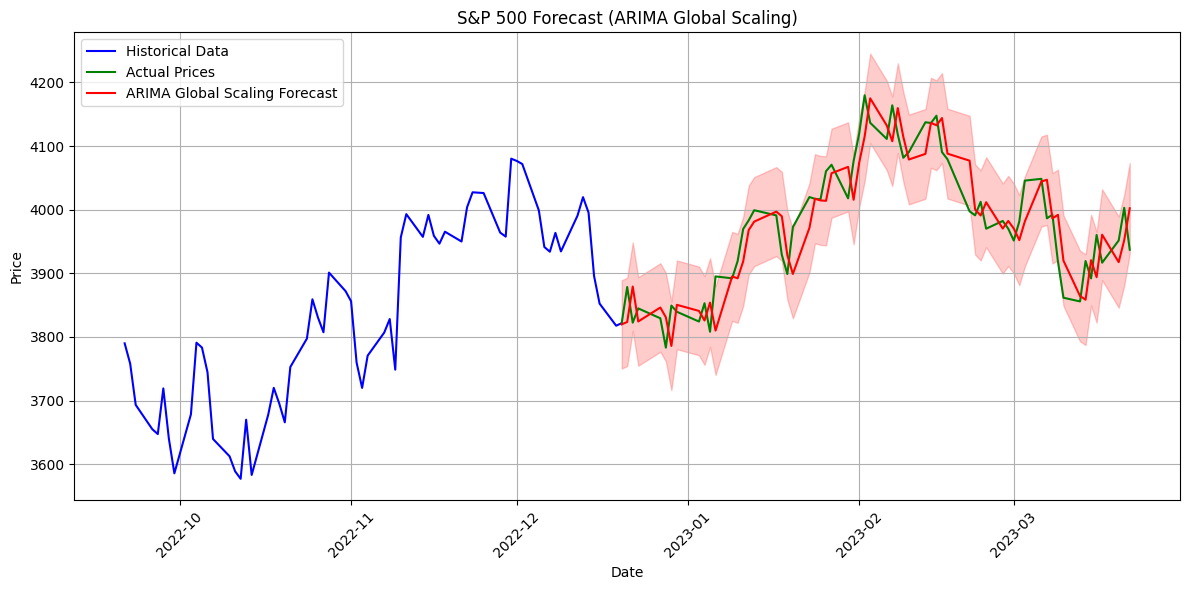

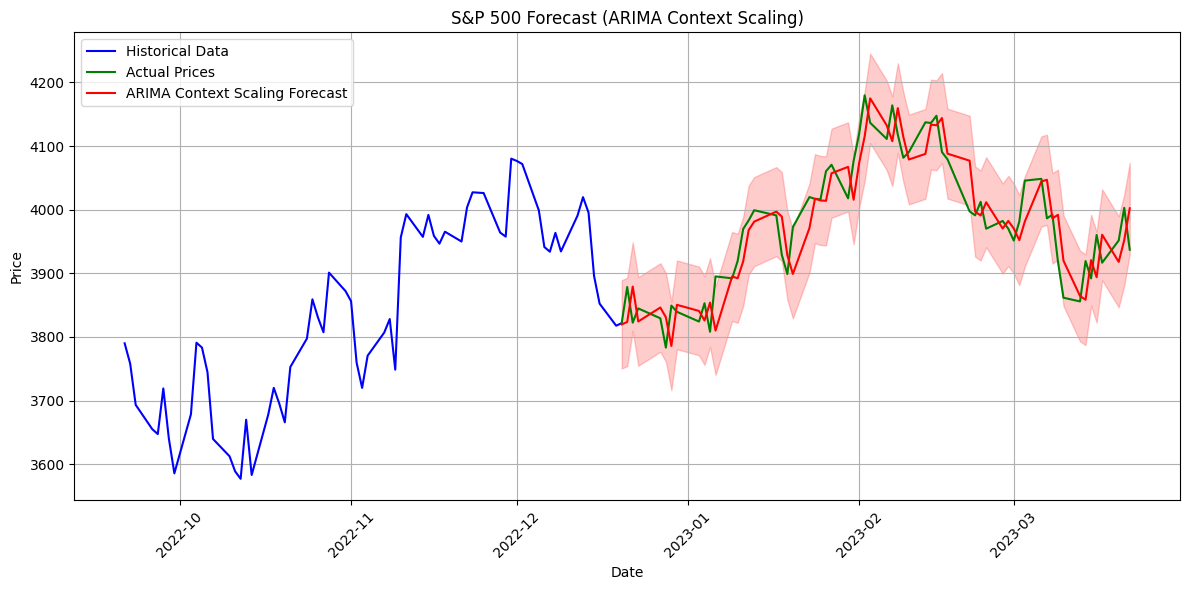

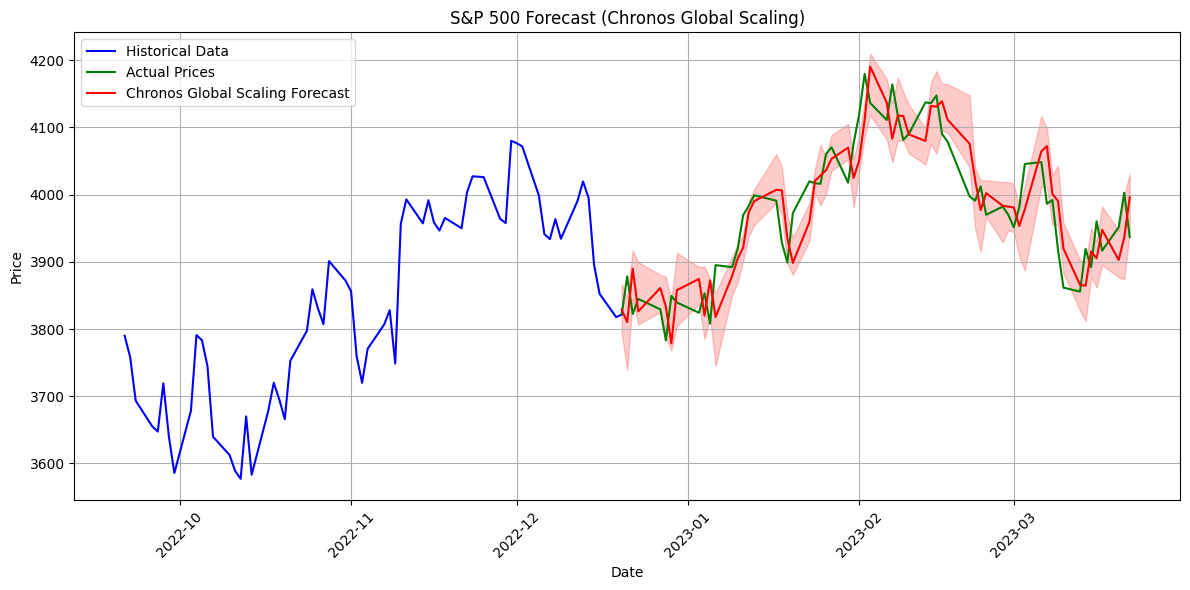

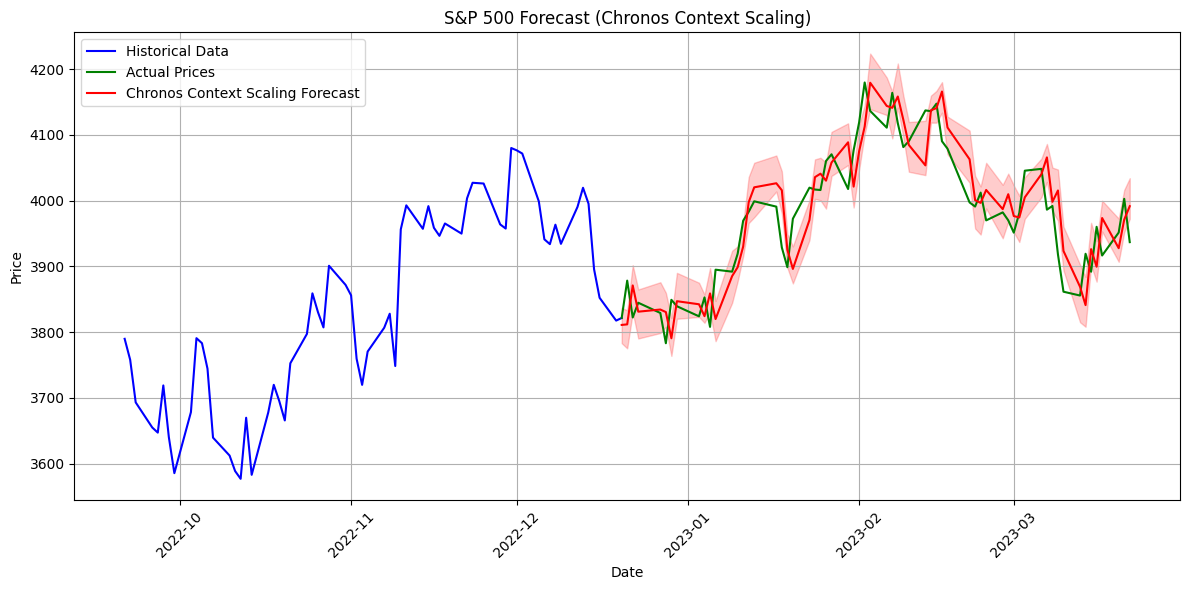

In [11]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from chronos import ChronosPipeline
from sklearn.preprocessing import StandardScaler

from utils.metrics import calculate_metrics
from data.snp500 import snp500_daily   

# Updated Constants
CONTEXT_WINDOW = 378
FORECAST_STEPS = 63
CONFIDENCE_ALPHA = 0.2
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1

# ======================
# Data Preparation
# ======================
def prepare_data(data):
    """Split data into indices for train/val/test sets"""
    n = len(data)
    train_end = int(TRAIN_RATIO * n)
    val_end = train_end + int(VAL_RATIO * n)
    return train_end, val_end

# ======================
# ARIMA Implementation (Fixed Scaling)
# ======================
class ARIMAPredictor:
    def __init__(self, train_data):
        self.scaler = StandardScaler()
        self.scaler.fit(train_data.reshape(-1, 1))  # Fit once on training data
        
    def generate_single_forecast(self, context_data):
        """ARIMA(1,1,1) one-step forecast"""
        try:
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            
            model = ARIMA(scaled_data, order=(1,1,1))
            model_fit = model.fit()
            forecast = model_fit.get_forecast(steps=1)
            
            median = self.scaler.inverse_transform([forecast.predicted_mean])[0][0]
            ci = self.scaler.inverse_transform(forecast.conf_int(alpha=CONFIDENCE_ALPHA))
            return ci[0][0], median, ci[0][1]
        except Exception as e:
            raise e
    
    def expanding_window_forecast(self, full_data, start_idx):
        """Forecast with expanding window using fixed scaling"""
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            # Ensure we have at least 2 samples for differencing
            if len(context_data) < 2:
                raise ValueError(f"Insufficient context data (need ≥2 samples, got {len(context_data)})")
            
            low, median, high = self.generate_single_forecast(context_data)
            
            # Fix date alignment
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Chronos Implementation (Fixed Scaling)
# ======================
class ChronosPredictor:
    def __init__(self, train_data):
        self.scaler = StandardScaler()
        self.scaler.fit(train_data.reshape(-1, 1))
        self.pipeline = ChronosPipeline.from_pretrained(
            "./ft_chronos_sp500_closing_rk2/checkpoint-final/",
            device_map="mps",
            torch_dtype=torch.bfloat16,
        )
        
    def generate_single_forecast(self, context_data):
        try:
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            context = torch.tensor(scaled_data, dtype=torch.bfloat16)
            
            forecast = self.pipeline.predict(context, 1)
            forecast_np = forecast[0].cpu().numpy()
            
            forecast_original = self.scaler.inverse_transform(forecast_np.reshape(-1, 1))
            return (
                np.quantile(forecast_original, 0.1).item(),
                np.quantile(forecast_original, 0.5).item(),
                np.quantile(forecast_original, 0.9).item()
            )
        except Exception as e:
            print(f"Chronos error: {str(e)}")
            last_val = self.scaler.inverse_transform([[context_data[-1]]])[0][0]
            return last_val*0.99, last_val, last_val*1.01

    def sliding_window_forecast(self, full_data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < CONTEXT_WINDOW:
                raise ValueError(f"Need at least {CONTEXT_WINDOW} samples for context")
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# ARIMA Implementation with Context Window Scaling
# ======================
class ARIMAPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        
    def generate_single_forecast(self, context_data):
        """ARIMA(1,1,1) one-step forecast with context window scaling"""
        try:
            # Fit scaler on context window
            self.scaler.fit(context_data.reshape(-1, 1))
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            
            model = ARIMA(scaled_data, order=(1,1,1))
            model_fit = model.fit()
            forecast = model_fit.get_forecast(steps=1)
            
            median = self.scaler.inverse_transform([forecast.predicted_mean])[0][0]
            ci = self.scaler.inverse_transform(forecast.conf_int(alpha=CONFIDENCE_ALPHA))
            return ci[0][0], median, ci[0][1]
        except Exception as e:
            raise e
    
    def expanding_window_forecast(self, full_data, start_idx):
        """Forecast with expanding window using context window scaling"""
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < 2:
                raise ValueError(f"Insufficient context data (need ≥2 samples, got {len(context_data)})")
            
            low, median, high = self.generate_single_forecast(context_data)
            
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Chronos Implementation with Context Window Scaling
# ======================
class ChronosPredictorContextScale:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pipeline = ChronosPipeline.from_pretrained(
            "./ft_chronos_sp500_closing_rk2/checkpoint-final/",
            device_map="mps",
            torch_dtype=torch.bfloat16,
        )
        
    def generate_single_forecast(self, context_data):
        try:
            # Fit scaler on context window
            self.scaler.fit(context_data.reshape(-1, 1))
            scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
            context = torch.tensor(scaled_data, dtype=torch.bfloat16)
            
            forecast = self.pipeline.predict(context, 1)
            forecast_np = forecast[0].cpu().numpy()
            
            forecast_original = self.scaler.inverse_transform(forecast_np.reshape(-1, 1))
            return (
                np.quantile(forecast_original, 0.1).item(),
                np.quantile(forecast_original, 0.5).item(),
                np.quantile(forecast_original, 0.9).item()
            )
        except Exception as e:
            print(f"Chronos error: {str(e)}")
            last_val = context_data[-1]
            return last_val*0.99, last_val, last_val*1.01

    def sliding_window_forecast(self, full_data, start_idx):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = max(0, current_idx - CONTEXT_WINDOW)
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            if len(context_data) < CONTEXT_WINDOW:
                raise ValueError(f"Need at least {CONTEXT_WINDOW} samples for context")
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

def run_multiple_trials_comparison(full_data, train_end, val_end, n_trials=1, test_start=None):
    """Run trials for both global and context scaling approaches"""
    train_data = full_data['Close'].iloc[:train_end].values
    test_start = val_end
    actual = full_data['Close'].iloc[test_start:test_start+FORECAST_STEPS].values
    
    # Global scaling ARIMA
    arima_global = ARIMAPredictor(train_data)
    insample_data = full_data['Close'].iloc[test_start - CONTEXT_WINDOW:test_start].values
    arima_global_preds = arima_global.expanding_window_forecast(full_data, test_start)
    arima_global_metrics = calculate_metrics(actual, arima_global_preds['median'], insample=insample_data)
    
    # Context window scaling ARIMA
    arima_context = ARIMAPredictorContextScale()
    arima_context_preds = arima_context.expanding_window_forecast(full_data, test_start)
    arima_context_metrics = calculate_metrics(actual, arima_context_preds['median'], insample=insample_data)
    
    # Global scaling Chronos
    chronos_global = ChronosPredictor(train_data)
    chronos_global_metrics_list = []
    chronos_global_preds = None
    
    # Context window scaling Chronos
    chronos_context = ChronosPredictorContextScale()
    chronos_context_metrics_list = []
    chronos_context_preds = None
    
    for trial in range(n_trials):
        # Global scaling trial
        chronos_global_preds = chronos_global.sliding_window_forecast(full_data, test_start)
        chronos_global_metrics = calculate_metrics(actual, chronos_global_preds['median'], insample=insample_data)
        chronos_global_metrics_list.append(chronos_global_metrics)
        
        # Context window scaling trial
        chronos_context_preds = chronos_context.sliding_window_forecast(full_data, test_start)
        chronos_context_metrics = calculate_metrics(actual, chronos_context_preds['median'], insample=insample_data)
        chronos_context_metrics_list.append(chronos_context_metrics)
        
        print(f"\nTrial {trial}")
        print("Global scaling metrics:", chronos_global_metrics)
        print("Context scaling metrics:", chronos_context_metrics)
    
    # Calculate statistics for Chronos
    chronos_global_avg = {metric: np.mean([m[metric] for m in chronos_global_metrics_list]) 
                         for metric in chronos_global_metrics_list[0]}
    chronos_global_std = {metric: np.std([m[metric] for m in chronos_global_metrics_list]) 
                         for metric in chronos_global_metrics_list[0]}
    
    chronos_context_avg = {metric: np.mean([m[metric] for m in chronos_context_metrics_list]) 
                          for metric in chronos_context_metrics_list[0]}
    chronos_context_std = {metric: np.std([m[metric] for m in chronos_context_metrics_list]) 
                          for metric in chronos_context_metrics_list[0]}
    
    return (arima_global_metrics, arima_context_metrics, 
            chronos_global_avg, chronos_global_std,
            chronos_context_avg, chronos_context_std,
            arima_global_preds, arima_context_preds,
            chronos_global_preds, chronos_context_preds)


def plot_individual_forecast(data, start_idx, forecasts, model_name):
    """Fixed plotting function with proper index alignment"""
    plt.figure(figsize=(12, 6))
    
    # Historical data (3 months before forecast start)
    historical_start = max(0, start_idx - 63)
    historical = data.iloc[historical_start:start_idx + 1]
    plt.plot(historical['Date'], historical['Close'], 'b-', label='Historical Data')
    
    # Actual values with CORRECTED indices
    actual_dates = data['Date'].iloc[start_idx:start_idx+FORECAST_STEPS]
    actual_values = data['Close'].iloc[start_idx:start_idx+FORECAST_STEPS]
    plt.plot(actual_dates, actual_values, 'g-', label='Actual Prices')
    
    # Forecasts with alignment validation
    forecast_dates = forecasts['dates']
    if len(forecast_dates) != FORECAST_STEPS:
        raise ValueError(f"Expected {FORECAST_STEPS} forecast dates, got {len(forecast_dates)}")
    
    # if model_name == "ARIMA Global Scaling" or "ARIMA Context Scaling":
    #     plt.plot(forecast_dates, forecasts['median'], 'r-', label=f'{model_name} Forecast')
    # else:     
    plt.plot(forecast_dates, forecasts['median'], 'r-', label=f'{model_name} Forecast')
    plt.fill_between(forecast_dates, forecasts['low'], forecasts['high'], color='red', alpha=0.2)
    
    plt.title(f'S&P 500 Forecast ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def main():
    data = snp500_daily.sort_values('Date')
    train_end, val_end = prepare_data(data)
    test_start = val_end
    
    results = run_multiple_trials_comparison(data, train_end, val_end, 10, test_start)
    (arima_global_metrics, arima_context_metrics, 
     chronos_global_avg, chronos_global_std,
     chronos_context_avg, chronos_context_std,
     arima_global_preds, arima_context_preds,
     chronos_global_preds, chronos_context_preds) = results
    
    # Print results
    print("\nARIMA Global Scaling Metrics:")
    for metric, value in arima_global_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nARIMA Context Window Scaling Metrics:")
    for metric, value in arima_context_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nChronos Global Scaling Metrics (Average ± Std):")
    for metric in chronos_global_avg:
        print(f"{metric}: {chronos_global_avg[metric]:.4f} ± {chronos_global_std[metric]:.4f}")
    
    print("\nChronos Context Window Scaling Metrics (Average ± Std):")
    for metric in chronos_context_avg:
        print(f"{metric}: {chronos_context_avg[metric]:.4f} ± {chronos_context_std[metric]:.4f}")
    
    # Plot results
    plot_individual_forecast(data, test_start, arima_global_preds, "ARIMA Global Scaling")
    plot_individual_forecast(data, test_start, arima_context_preds, "ARIMA Context Scaling")
    plot_individual_forecast(data, test_start, chronos_global_preds, "Chronos Global Scaling")
    plot_individual_forecast(data, test_start, chronos_context_preds, "Chronos Context Scaling")

if __name__ == "__main__":
    main()